In [2]:
%%bash
pip -q install pydicom opencv-python scikit-image pyradiomics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.4/116.4 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 42.4 MB/s eta 0:00:00


In [27]:
import cv2 as cv
import numpy as np
import os
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from joblib import dump, load
from sklearn.neural_network import MLPClassifier
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from joblib import dump, load
from PIL import Image, ImageFilter, ImageChops
from skimage import feature
from random import random
from random import uniform
from sklearn import svm
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import radiomics
from radiomics import featureextractor
import SimpleITK as sitk

### Read images

In [30]:
def read_images(input_path):
    """
    Read images in the input_path,
    save image, patient of each image and the class (group/labels)

    Params:
    input_path = path to the original images

    Return:
    images = list of all images
    labels = list with class for each image
    """

    # Lists to save images, patients and labels
    images = []
    labels = []
    names = []

    # Browse input path
    for class_dir in os.listdir(input_path):
        class_path = os.path.join(input_path, class_dir)

        # If it is a directory
        if os.path.isdir(class_path):

            for image_file in os.listdir(class_path):

                image_name = f'{image_file[:-4]}_{class_dir[0]}'

                image_path = os.path.join(class_path, image_file)

                image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)

                # Append image, patient id and class to list
                images.append(image)
                labels.append(class_dir)
                names.append(image_name)

    return (images, labels, names)

In [14]:
%%bash
wget https://www.inf.ufpr.br/vsa20/dataset.tar.gz
#curl -0 https://www.inf.ufpr.br/vsa20/dataset.tar.gz
#tar -xf /content/dataset.tar.gz

--2023-11-26 13:38:39--  https://www.inf.ufpr.br/vsa20/dataset.tar.gz
Resolving www.inf.ufpr.br (www.inf.ufpr.br)... 200.17.202.113, 2801:82:80ff:8001:216:ccff:feaa:79
Connecting to www.inf.ufpr.br (www.inf.ufpr.br)|200.17.202.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89910813 (86M) [application/octet-stream]
Saving to: ‘dataset.tar.gz’

     0K .......... .......... .......... .......... ..........  0%  412K 3m33s
    50K .......... .......... .......... .......... ..........  0%  413K 3m33s
   100K .......... .......... .......... .......... ..........  0%  419K 3m32s
   150K .......... .......... .......... .......... ..........  0% 30.6M 2m39s
   200K .......... .......... .......... .......... ..........  0% 53.1M 2m8s
   250K .......... .......... .......... .......... ..........  0% 1.27M 1m58s
   300K .......... .......... .......... .......... ..........  0%  620K 2m1s
   350K .......... .......... .......... .......... ..........  0% 30.0M 

In [15]:
!tar -xf /content/dataset.tar.gz

### Preprocessing

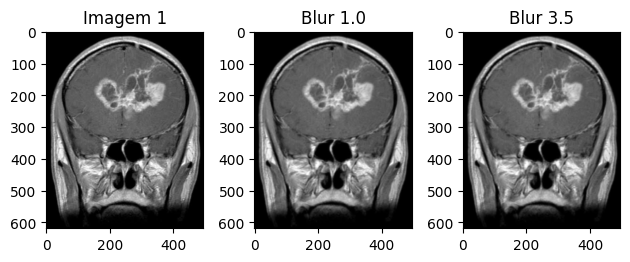

In [24]:
""" Testing filters """

image = cv.imread('/content/dataset/test/glioma_tumor/image(1).jpg', cv.IMREAD_GRAYSCALE)
norm_image = cv.normalize(image, None, 0, 255, cv.NORM_MINMAX, dtype=cv.CV_32F)
blur_image = cv.GaussianBlur(norm_image, (0, 0), 1.0)
blur_image2 = cv.GaussianBlur(norm_image, (0, 0), 3.5)

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Imagem 1')

plt.subplot(1, 3, 2)
plt.imshow(blur_image, cmap='gray')
plt.title('Blur 1.0')

plt.subplot(1, 3, 3)
plt.imshow(blur_image, cmap='gray')
plt.title('Blur 3.5')

# Ajustar o layout para evitar sobreposições
plt.tight_layout()

plt.show()

In [64]:
def preprocessing(images_data):

    for key, value in images_data.items():

        image = value[0]
        label = value[1]

        norm_image = cv.normalize(image, None, 0, 1.0, cv.NORM_MINMAX, dtype=cv.CV_32F)
        blur_image = cv.GaussianBlur(norm_image, (0, 0), 3.5)

        images_data[key] = (blur_image, label)

    return images_data

In [65]:
x_train, y_train, images_names_train = read_images("/content/dataset/train")
x_test, y_test, images_names_test = read_images("/content/dataset/test")

In [66]:
def assemble_data(x, y, names):

  images_data = {}

  for i in range(len(names)):
      name = names[i]
      image = x[i]
      label = y[i]

      images_data[name] = (image, label)

  return images_data

images_data_train = assemble_data(x_train, y_train, images_names_train)
images_data_test = assemble_data(x_test, y_test, images_names_test)

In [67]:
# run preprocessing
images_data_train = preprocessing(images_data_train)
images_data_test = preprocessing(images_data_test)

### Extract features

In [ ]:
# Extract grayscale features
def extract_grayscale(data):

    ft_gray = []

    for image in data:

        shape = image.shape
        ft_gray.append(np.reshape(image, (shape[0]*shape[1])))

    return ft_gray

In [ ]:
# Extract feature: length of the edges
def extract_edges_len(data):

    ft_edges_len = []

    for image in data:

        edges = feature.canny(image)

        # Extract the edge pixels
        edge_pixels = edges.nonzero()

        # Calculate the edge length for each edge pixel
        edge_lengths = []

        for i, j in zip(*edge_pixels):
            # Get the coordinates of the current pixel
            x, y = j, i

            # Check if there's a next pixel in the edge segment
            if x > 0:
                # Get the coordinates of the next pixel
                x2 = edge_pixels[0][x - 1]
                y2 = edge_pixels[1][x - 1]
            else:
                # Handle the edge case where there's no next pixel
                x2 = edge_pixels[0][-1]
                y2 = edge_pixels[1][-1]

            # Calculate the distance between the two pixels
            distance = np.sqrt((x2 - x)**2 + (y2 - y)**2)

            # Add the distance to the list of edge lengths
            edge_lengths.append(distance)

        ft_edges_len.append(edge_lengths)

    return ft_edges_len

In [ ]:
def run_extractor(images_data, extractor):
    """
    Extract features using sitk and pyradiomics

    Params:
    imgs = raw images
    otsu = masked images with otsu thresholding
    adapt = masked images with adaptative thresholding
    extractor = pyradiomics extractor

    Returns:
    features_otsu = features for otsu mask
    features_adapt = features for adaptative mask
    """

    data_spacing=[1,1,1]
    features = {}

    for key, value in images_data.items():

        # Get raw and Otsu`s images
        img = value[0]

        _, thr = cv.threshold(img, 100, 1, cv.THRESH_BINARY+cv.THRESH_OTSU)

        sitk_img = sitk.GetImageFromArray(img)
        sitk_img.SetSpacing((1, 1, 1))
        sitk_img = sitk.JoinSeries(sitk_img)

        sitk_thr = sitk.GetImageFromArray(thr)
        sitk_thr.SetSpacing((1, 1, 1))
        sitk_thr = sitk.JoinSeries(sitk_thr)
        sitk_thr = sitk.Cast(sitk_thr, sitk.sitkInt32)

        # Extract features and append them to the proper list
        try:

            ft_adapt = extractor.execute(sitk_img, sitk_thr)
            features[key] = ft_adapt

        except:
            #print(f"{key}, ", end="")
            pass

    return features


def conditional_append(element, dest):
    """
    Append element to the list destiny, if element is not in destiny

    Params:
    element = an element of any kind
    dest = a destination list

    Returns:
    destiny = list with appended element if the element was not in there
    """
    if element not in dest:
        dest.append(element)

    return dest

def process_features(features):
    """
    Process features, in a way that:
    - features that are dictionaries and strings are removed
    - features that are tuples are separated and each element
    of the tuple is considered one feature
    - other types are converted to float

    Params:
    feats_o = list of Otsu's threshold features
    feats_a = list of adaptativa threshold features

    Returns:
    all_feats_o = Otsu's features processed
    all_feats_a = adaptative features processed
    names = feature names processed
    """

    all_feats = {}
    names = []

    # For each image in one of the features list
    for key, value in features:

        values = []

        # For each feature in the list
        for ft in value:

            # Get the feature's value
            ft_value = value[ft]

            # If the value is str or dict, ignore it
            if type(ft_value) == str or type(ft_value) == dict:
                continue
            # If it's a tuple
            elif type(ft_value) == tuple:
                for e in range(len(ft_value)):
                    # Add and index to the feature name
                    conditional_append(f'{ft}_{e}', names)
                    # Append float values to the lists
                    values.append(float(ft_value[e]))
            # For other data types, just append the name and float values
            else:
                conditional_append(ft, names)
                values.append(float(ft_value[e]))

        # Append processed features to the general list
        all_feats[key] = values

    return all_feats, names

def extract_radiomics(images_data):
    """
    Process features, in a way that:
    - features that are dictionaries and strings are removed
    - features that are tuples are separated and each element
    of the tuple is considered one feature
    - other types are converted to float
    Get the features' names, with tuple features indexed

    Params:
    folds = list of tuples containing x_train raw and with thresholds

    Returns:
    all_folds_feats = dictionary containing Otsu's features and adaptive
    features for each fold
    names = feature names
    """

    # Create feature extractor
    !wget -c https://raw.githubusercontent.com/AIM-Harvard/pyradiomics/master/examples/exampleSettings/Params.yaml
    params = 'Params.yaml'
    settings = {'label': 1, 'correctMask': True}
    extractor = featureextractor.RadiomicsFeatureExtractor(params, additionalInfo=True, **settings)

    # Extract features from Otsu's and adaptative
    features = run_extractor(images_data, extractor)

    # Process features and get feature names
    features, names = process_features(features)

    return features, names

In [ ]:
# Extract features: LBP
def extract_lbp(data, eps=1e-7, points=24, radius=8):

    ft_lbp = []

    for image in data:

        lbp = feature.local_binary_pattern(image,
                                           points,
                                           radius,
                                           method="uniform")

        (hist, _) = np.histogram(lbp.ravel(),
                                 bins = np.arange(0, points + 3),
                                                 range=(0, points + 2))

        # normalize the histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)

        ft_lbp.append(hist)

    # return the histogram of Local Binary Patterns
    return ft_lbp

In [ ]:
#ft_gray = extract_grayscale(x_train)

In [ ]:
ft_edges_len = extract_edges_len(x_train)

In [ ]:
ft_lbp = extract_lbp(x_train)

In [ ]:
ft_radiomics = extract_radiomics(images_data)

--2023-11-25 14:24:42--  https://raw.githubusercontent.com/AIM-Harvard/pyradiomics/master/examples/exampleSettings/Params.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



INFO:radiomics.featureextractor:Loading parameter file Params.yaml
INFO:radiomics.featureextractor:Applying custom setting overrides: {'additionalInfo': True, 'label': 1, 'correctMask': True}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with c

In [ ]:
def save_features(features, image_names, out_path):

    ft_edges_len = dict(zip(image_names, features))

    os.makedirs(features, exist_ok=True)

    for key in ft_lbp:

        ft = ft_edges_len[key]

        filename = f'{key}.txt'

        with open(os.path.join(out_path, filename), 'w') as f:
            for elem in ft:
                f.write(f'{elem}\n')


In [ ]:
save_features(ft_lbp, images_names, 'ft_lbp')
save_features(ft_radiomics, images_names, 'ft_radiomics')

Get feature names and table

In [ ]:
# max_edges_count = 0
# for sample in ft_edges_len:
#     edges_count = len(sample)

#     if edges_count > max_edges_count:
#         max_edges_count = edges_count

# names_gray = [f'gray{i}' for i in range(len(ft_gray[0]))]
#names_edges = [f'edges{i}' for i in range(max_edges_count)]
names_lbp = [f'lbp{i}' for i in range(len(ft_lbp[0]))]



In [ ]:
# Download features
!zip -r /content/ft_lbp.zip /content/ft_lbp
!zip -r /content/ft_edges_len.zip /content/ft_radiomics

from google.colab import files
files.download("/content/ft_lbp.zip")
files.download("/content/ft_radiomics.zip")

Streaming output truncated to the last 5000 lines.
  adding: content/ft_edges_len/p (400)_p_edges.txt (deflated 54%)
  adding: content/ft_edges_len/m1(83)_m_edges.txt (deflated 54%)
  adding: content/ft_edges_len/p (540)_p_edges.txt (deflated 53%)
  adding: content/ft_edges_len/gg (334)_g_edges.txt (deflated 54%)
  adding: content/ft_edges_len/image(275)_n_edges.txt (deflated 56%)
  adding: content/ft_edges_len/p (804)_p_edges.txt (deflated 54%)
  adding: content/ft_edges_len/m (122)_m_edges.txt (deflated 54%)
  adding: content/ft_edges_len/gg (727)_g_edges.txt (deflated 54%)
  adding: content/ft_edges_len/gg (113)_g_edges.txt (deflated 53%)
  adding: content/ft_edges_len/m (84)_m_edges.txt (deflated 54%)
  adding: content/ft_edges_len/p (446)_p_edges.txt (deflated 53%)
  adding: content/ft_edges_len/gg (125)_g_edges.txt (deflated 53%)
  adding: content/ft_edges_len/image(164)_n_edges.txt (deflated 56%)
  adding: content/ft_edges_len/image (9)_n_edges.txt (deflated 53%)
  adding: conte

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
with open('ft_edges_names.txt', 'w') as f:
    f.write('\n'.join(names_edges))

with open('ft_lbp_names.txt', 'w') as f:
    f.write('\n'.join(names_lbp))

In [ ]:
#df_gray = pd.DataFrame(ft_gray, columns = names_gray)
df_edges = pd.DataFrame(ft_edges_len, columns = names_edges, index = image_names)
#df_lbp = pd.DataFrame(ft_lbp, columns = names_lbp, index = image_names)

# df = pd.concat([df_edges, df_lbp], axis = 1)

# # Create a LabelEncoder object
# df['label'] = y_train
# le = LabelEncoder()
# le.fit(df['label'])
# df['label'] = le.transform(df['label'])

# df = df.reset_index()

In [ ]:
df_edges.isna().sum()

edges0           0
edges1           0
edges2           0
edges3           0
edges4           0
              ... 
edges82722    2869
edges82723    2869
edges82724    2869
edges82725    2869
edges82726    2869
Length: 82727, dtype: int64

In [ ]:
df_edges.to_csv("/content/df_edges.csv")

KeyboardInterrupt: ignored

### PSO

In [ ]:
# numero total de features disponiveis
max_feature_id = 50

In [ ]:
# number of dimensions
# i.e. feature number for each particle
n_dimensions = 3

# initial particles position
# since we can't use the same feature repeated,
# the initial position has features ranging from 0 to n_features
initial_pos = []
for i in range(n_dimensions):
    initial_pos.append(i)

# min and max values for the features
# 0 is the id for the first feature,
# and max_feature_id is the id for the last feature
bounds = [(0, max_feature_id)]*n_dimensions



In [ ]:
def cost_function(x):
    total=0
    for i in range(len(x)):
        total+=x[i]**2
    return total

In [ ]:
class Particle:
    def __init__(self, initial_pos):

        self.position_i = []          # particle position, i.e. features
        self.velocity_i = []          # particle velocity
        self.pos_best_i = []          # best position individual
        self.err_best_i = -1          # best error individual
        self.err_i = -1               # error individual

        # intiialize position
        self.position_i = initial_pos
        # intiialize velocity as values between -1 and 1
        for i in range(0, n_dimensions):
            self.velocity_i.append(uniform(-1,1))

    # evaluate current fitness
    def evaluate(self, costFunc):
        self.err_i = costFunc(self.position_i)

        # check to see if the current position is an individual best
        if self.err_i < self.err_best_i or self.err_best_i == -1:
            self.pos_best_i = self.position_i.copy()
            self.err_best_i = self.err_i

    # update new particle velocity
    def update_velocity(self, pos_best_g, w, c1, c2):

        # constant inertia weight (how much to weigh the previous velocity)
        # cognitive constant (influences pbest)
        # social constant (influences gbest)

        for i in range(0, n_dimensions):

            # non-deterministic values to prevent particles
            # from getting stuck in local optima
            r1 = random()
            r2 = random()

            # update cognitive and social
            vel_cognitive = c1 * r1 * (self.pos_best_i[i] - self.position_i[i])
            vel_social = c2 * r2 * (pos_best_g[i] - self.position_i[i])

            self.velocity_i[i] = w * self.velocity_i[i] + vel_cognitive + vel_social

    # update the particle position based off new velocity updates
    def update_position(self,bounds):
        for i in range(0, n_dimensions):
            self.position_i[i] = round(self.position_i[i] + self.velocity_i[i])

            # adjust maximum position if necessary
            if self.position_i[i] > bounds[i][1]:
                self.position_i[i] = bounds[i][1]

            # adjust minimum position if neseccary
            if self.position_i[i] < bounds[i][0]:
                self.position_i[i] = bounds[i][0]


def minimize(cost_function, initial_pos, bounds, n_particles,
             n_dimensions, maxiter, verbose=False):

    err_best_g = -1                   # best error for group
    pos_best_g = []                   # best position for group

    # establish the swarm
    swarm = []
    for i in range(0, n_particles):
        swarm.append(Particle(initial_pos, n_dimensions))

    # begin optimization loop
    i = 0
    while i < maxiter:
        if verbose: print(f'iter: {i:>4d}, best solution: {err_best_g:10.6f}')

        # cycle through particles in swarm and evaluate fitness
        for j in range(0, n_particles):
            swarm[j].evaluate(cost_function)

            # determine if current particle is the best (globally)
            if swarm[j].err_i < err_best_g or err_best_g == -1:
                pos_best_g = swarm[j].position_i
                err_best_g = float(swarm[j].err_i)

        # cycle through swarm and update velocities and position
        for j in range(0, n_particles):
            swarm[j].update_velocity(pos_best_g)
            swarm[j].update_position(bounds)

        i+=1

    # print final results
    if verbose:
        print('\nFINAL SOLUTION:')
        print(f'   > {pos_best_g}')
        print(f'   > {err_best_g}\n')

    return err_best_g, pos_best_g

In [ ]:
minimize(sphere, initial, bounds, num_particles=15, maxiter=30, verbose=True)